In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
from uniform_attachment_model  import matrix_uniform_attachment
from tqdm.notebook import tqdm
import pandas as pd
import time

0.11748123168945312


In [2]:
def find_barycenter_prob(matrix, vertex_to_remove):

    matrix_copy = copy.deepcopy(matrix)

    row_c = [0, 1]

    for i in vertex_to_remove:
        if vertex_to_remove.count(i) >= 2:
            return i  

    while len(row_c) != 0:
        row, column = row_colum_returner(matrix_copy, vertex_to_remove)
        row_c = row

        if len(row_c) == 0:
            break

        for r, c in zip(row, column):
            matrix_copy = make_that_1_into_0_with_transpose(matrix_copy, r, c)

 
    for s, i in enumerate(matrix_copy):
        if sum(i) == 3:
            return s  #

    for i in vertex_to_remove:
        if sum(matrix_copy[i]) == 2:
            return i  

 
    return None
def row_colum_returner(matrix, vertex_to_remove):
    s= 0 
    column = []
    row = []
    for i in matrix:
        if sum(i) == 1:
            if s in vertex_to_remove:
                pass
            if s not in vertex_to_remove:
                d = 0
                for v in i:
                    if v==1:
                        row.append(s)
                        column.append(d)
                    d+=1
                        
    
        s+=1

    return row, column

def calculate_u_new(matrix):
    row_count = max(len(i) for i in matrix)
    u_new = [0] * row_count
    u_old = [1 / row_count] * row_count
    
    for i in range(0, row_count):
        for j in range(0, row_count):
            for k in range(0, row_count):
                center = find_barycenter_prob(matrix, vertex_to_remove=[i, j, k])
                u_new[center] += u_old[i] * u_old[j] * u_old[k]
    
    return u_new


def find_barycenter_deterministic(adj_matrix):
    leaf_cut = []    
    adj_matrix_copy = copy.deepcopy(adj_matrix)
    
    n = len(adj_matrix_copy)  # Number of nodes, number of rows
    degrees = np.sum(adj_matrix_copy, axis=1)  # Sum of row = degree
    nodes = set(range(n))  # All vertices
    
    while len(nodes) > 2: 
        # Find all leaf nodes (nodes with degree 1)
        leaf_nodes = [i for i in nodes if degrees[i] == 1]  # Only those with a single 1 are leaves
        
        for leaf in leaf_nodes:
            nodes.remove(leaf)  # Remove the leaf
            degrees[leaf] = 0  # Degree is then 0

            for neighbor in range(n):  # Check all neighbors
                if adj_matrix_copy[leaf][neighbor] == 1:  # If there is a connection
                    degrees[neighbor] -= 1  # Decrement the degree of the neighbor
                    adj_matrix_copy[leaf][neighbor] = 0  # Change the 1 to 0
                    adj_matrix_copy[neighbor][leaf] = 0  # Also change its "transpose position" to 0
        leaf_cut.append(1)

    # At this point, there should only be 1 or 2 nodes left
    remaining_nodes = list(nodes)  # Convert the set to a list

    if len(remaining_nodes) == 1:  # If only 1 vertex remains
        return remaining_nodes, adj_matrix_copy, sum(leaf_cut)
    elif len(remaining_nodes) == 2:  # If 2 vertices remain
        return remaining_nodes, adj_matrix_copy, sum(leaf_cut)

def make_that_1_into_0_with_transpose(matrix, row, column):
    matrix[row][column] = 0
    matrix[column][row] = 0


    return matrix

def draw_graph_from_adjacency_matrix(adjacency_matrix):
    G = nx.Graph()

    for i in range(len(adjacency_matrix)):
        for j in range(len(adjacency_matrix[i])):
            if adjacency_matrix[i][j] != 0: 
                G.add_edge(i, j, weight=adjacency_matrix[i][j])


    G.add_nodes_from(range(len(adjacency_matrix)))

    pos = nx.spring_layout(G, seed=42)

    # Draw the graph
    plt.figure(figsize=(8, 6))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color='lightblue',
        edge_color='black',
        node_size=10,
        font_size=10,
        width=0.5
    )
    plt.title("Graph from Adjacency Matrix")
    plt.show()


In [3]:
def calculate_u_new(matrix, u_old = None):
    row_count = max(len(i) for i in matrix)
    u_new = [0] * row_count

    if u_old is None:
        u_old = [1 / row_count] * row_count
    
    for i in range(0, row_count):
        for j in range(0, row_count):
            for k in range(0, row_count):
                center = find_barycenter_prob(matrix, vertex_to_remove=[i, j, k])
                u_new[center] += u_old[i] * u_old[j] * u_old[k]
    
    return u_new

In [4]:
def entropy_calculator(list_s):
    entropy_sum_list = []
    for i in list_s:
        if i < 0.0000000001:
            value = 0
        else:
            value = i * np.log(i)
            entropy_sum_list.append(value)
    
    return -sum(entropy_sum_list)

In [5]:
def main_entropy_for_each_interation(n, matrix):
    start_time = time.time() 
    total_steps = n
    progress_bar = tqdm(total=total_steps, desc="Computing", dynamic_ncols=True)

    list_with_all_iteration = []
    u_old = None

    for s in range(n):
        elapsed_time = time.time() - start_time
        progress_bar.set_description(f"Elapsed: {elapsed_time:.2f} sec")
        u_calculated = calculate_u_new(matrix, u_old)
        entropy_received = (entropy_calculator(u_calculated)).round(4)
        u_old = u_calculated

        dict_2_send = {
            "interation": s,
            "entropy": entropy_received,
            'u_calculated': u_calculated
        }
        list_with_all_iteration.append(dict_2_send)

        if entropy_received < np.log(2).round(10):  
            progress_bar.n = total_steps  # Set progress to max
            progress_bar.refresh()  # Force update the UI
            progress_bar.close
            break  

        progress_bar.update(1)  

    progress_bar.close()  
    return list_with_all_iteration


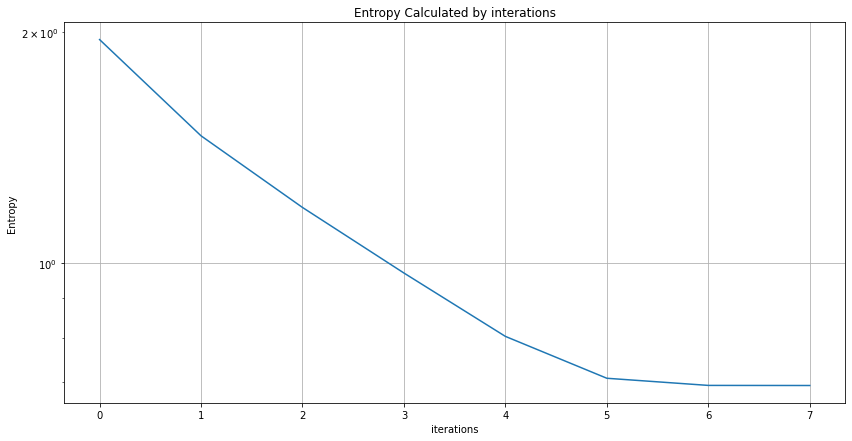

In [265]:
plt.figure(figsize=(14, 7))
plt.semilogy(final_df['interation'],final_df['entropy'])
plt.title("Entropy Calculated by interations")
plt.xlabel("iterations")
plt.ylabel("Entropy")
plt.grid()
plt.show()

In [7]:
s = set(range(50))
all_list = []
important_list = []
for i in s:
    matrix = matrix_uniform_attachment(i)
    given_list = main_entropy_for_each_interation(10, matrix)
    dict_2_send = {
        'node_size':i,
        'iteration_required':len(given_list)
    }
    all_list.append(given_list)
    important_list.append(dict_2_send)

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

In [10]:
important_df = pd.DataFrame(important_list)
random_crap_df = pd.DataFrame(all_list)
important_df.to_csv("barycenter_interations_required.csv")
random_crap_df.to_csv("baruycenter_interactions_backup.csv")

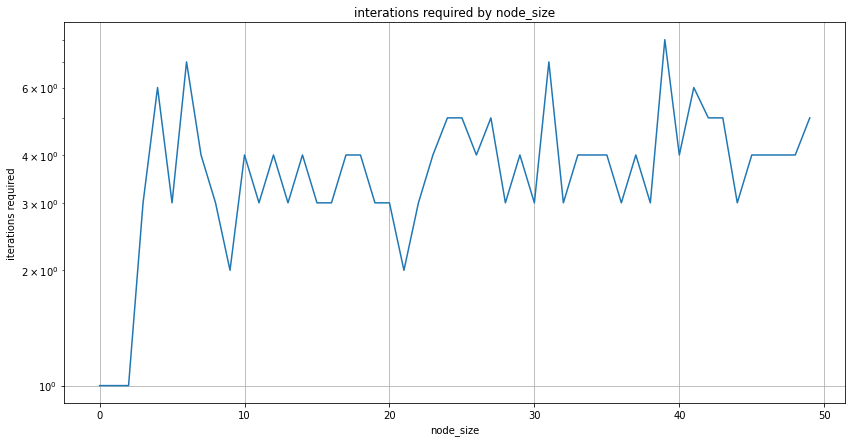

In [12]:
plt.figure(figsize=(14, 7))
plt.semilogy(important_df['node_size'],important_df['iteration_required'])
plt.title("interations required by node_size")
plt.xlabel("node_size")
plt.ylabel("iterations required")
plt.grid()
plt.show()

In [182]:
import copy
import numpy as np

def make_that_1_into_0_with_transpos(matrix, row, column):
    matrix[row][column] = 0
    matrix[column][row] = 0

    
def merge_trees(matrix_1, matrix_2, random_vertex_selection = True, vertex_from_matrix_1 = None, vertex_from_matrix_2 = None):
    matrix_1_cp = copy.deepcopy(matrix_1)
    matrix_2_cp = copy.deepcopy(matrix_2)


    for i in range(len(matrix_2_cp)):
        for li in matrix_1_cp:
            li.append(0)


    for i in range(len(matrix_1_cp)):
        for li in matrix_2_cp:
            li.insert(0, 0)
        


    for row in matrix_2_cp:
        matrix_1_cp.append(row)

    if random_vertex_selection: 
        vertex_for_matrix_1 = np.random.choice(list(range(len(matrix_1))))
        vertex_for_matrix_2_og = np.random.choice(list(range(len(matrix_2))))
        vertex_2_to_change = vertex_for_matrix_2_og + len(matrix_1)
        print(f"vertex {vertex_for_matrix_1} from matrix_1 and {vertex_for_matrix_2_og} from matrix_2_were chosen")
        matrix_final = make_that_0_into_1_with_transpose(matrix_1_cp, vertex_for_matrix_1, vertex_2_to_change)
        return matrix_final, vertex_for_matrix_1, vertex_for_matrix_2_og

    else:
        if vertex_from_matrix_1 is None:
            vertex_for_matrix_1 = np.random.choice(list(range(len(matrix_1))))
            vertex_2_to_change = vertex_from_matrix_2 + len(matrix_1)
            print(f"vertex {vertex_for_matrix_1} from matrix_1 and {vertex_from_matrix_2} from matrix_2_were chosen")
            matrix_final = make_that_0_into_1_with_transpose(matrix_1_cp, vertex_for_matrix_1, vertex_2_to_change)
            return matrix_final, vertex_for_matrix_1, vertex_from_matrix_2
            
        else:
            vertex_for_matrix_1 = vertex_from_matrix_1
            vertex_2_to_change = vertex_from_matrix_2 + len(matrix_1)
            print(f"vertex {vertex_for_matrix_1} from matrix_1 and {vertex_from_matrix_2} from matrix_2_were chosen")
            matrix_final = make_that_0_into_1_with_transpose(matrix_1_cp, vertex_for_matrix_1, vertex_2_to_change)
            return matrix_final, vertex_for_matrix_1, vertex_from_matrix_2



In [187]:
from reg_three_g import make_that_0_into_1_with_transpose
from line_tree import create_line_tree_adjacency_matrix

In [193]:
matrix_1 = (matrix_uniform_attachment(9))
matrix_2 = create_line_tree_adjacency_matrix(9)
line_simgle = create_line_tree_adjacency_matrix(2)
matrix_left, vertex_from_1, vertex_from_2 = merge_trees(line_simgle, matrix_1, random_vertex_selection=True)
possible_answer = list(set(range(len(line_simgle))))
if possible_answer[vertex_from_1] == 0 :
    value_for_2 = 1
else:
    value_for_2 = 0
matrix_total, v1, v2 = merge_trees(matrix_2,matrix_left, random_vertex_selection=False, vertex_from_matrix_1=None, vertex_from_matrix_2=value_for_2)

vertex 0 from matrix_1 and 7 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


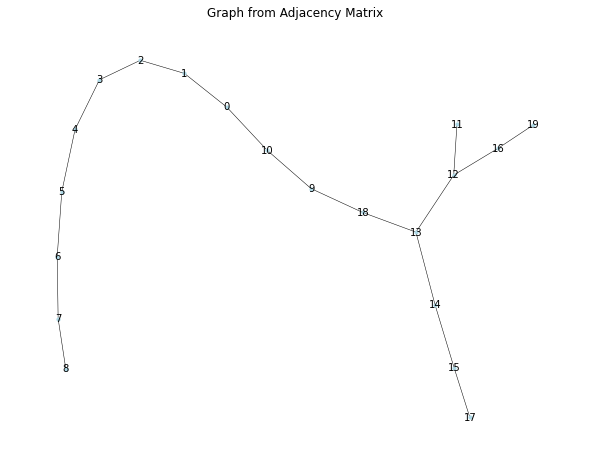

In [194]:
draw_graph_from_adjacency_matrix(matrix_total)

In [195]:
answerable_list = main_entropy_for_each_interation(10, matrix_total)

[0.07325000000000005, 0.07025000000000005, 0.06575000000000004, 0.059750000000000046, 0.05225000000000004, 0.04325000000000003, 0.03275000000000002, 0.020750000000000015, 0.007250000000000006, 0.07475000000000005, 0.07475000000000005, 0.007250000000000006, 0.06875000000000005, 0.18724999999999323, 0.03275000000000002, 0.020750000000000015, 0.020750000000000015, 0.007250000000000006, 0.07325000000000005, 0.007250000000000006]
[0.10422675659374898, 0.09106675221874921, 0.07360422378124959, 0.05419981503124959, 0.03541452096874984, 0.019574987843749902, 0.008315188156249945, 0.00215117065624999, 0.00015692534374999926, 0.11128965940624842, 0.1112896594062487, 0.00015692534374999928, 0.027733250656249854, 0.2436620278437392, 0.008315188156249945, 0.0021511706562499905, 0.00215117065624999, 0.00015692534374999923, 0.10422675659374817, 0.00015692534374999926]
[0.13907654390228755, 0.09898696057642475, 0.05813338919498928, 0.02727516391533713, 0.009669455455711438, 0.002344564399807145, 0.000

In [196]:
from reg_three_g import final_3_reg_tree

In [210]:
matrix_reg_three = final_3_reg_tree(3)

In [211]:
len(matrix_reg_three)

22

In [212]:
matrix_line = create_line_tree_adjacency_matrix(22)

In [213]:
from uniform_attachment_model import matrix_uniform_attachment

In [214]:
matrix_random = matrix_uniform_attachment(22)

In [215]:
answerable_list_1 = main_entropy_for_each_interation(10, matrix_reg_three)
answerable_list_2 = main_entropy_for_each_interation(10, matrix_line)
answerable_list_3 = main_entropy_for_each_interation(10, matrix_random)

[0.28211870773853287, 0.13786626596544202, 0.13786626596544202, 0.13786626596544202, 0.03869271224643109, 0.03869271224643109, 0.03869271224643109, 0.03869271224643109, 0.03869271224643109, 0.03869271224643109, 0.006010518407212619, 0.006010518407212619, 0.006010518407212619, 0.006010518407212619, 0.006010518407212619, 0.006010518407212619, 0.006010518407212619, 0.006010518407212619, 0.006010518407212619, 0.006010518407212619, 0.006010518407212619, 0.006010518407212619]
[0.5668603773958379, 0.12947028772743271, 0.12947028772743274, 0.12947028772743274, 0.007238903799753512, 0.0072389037997535105, 0.007238903799753508, 0.007238903799753505, 0.007238903799753503, 0.0072389037997535, 0.00010794471860911115, 0.00010794471860911115, 0.00010794471860911115, 0.00010794471860911118, 0.00010794471860911118, 0.00010794471860911118, 0.00010794471860911118, 0.00010794471860911118, 0.0001079447186091112, 0.0001079447186091112, 0.0001079447186091112, 0.0001079447186091112]
[0.8304481329821297, 0.056

In [216]:
final_df_1 = pd.DataFrame(answerable_list_1)
final_df_2 = pd.DataFrame(answerable_list_2)
final_df_3 = pd.DataFrame(answerable_list_3)

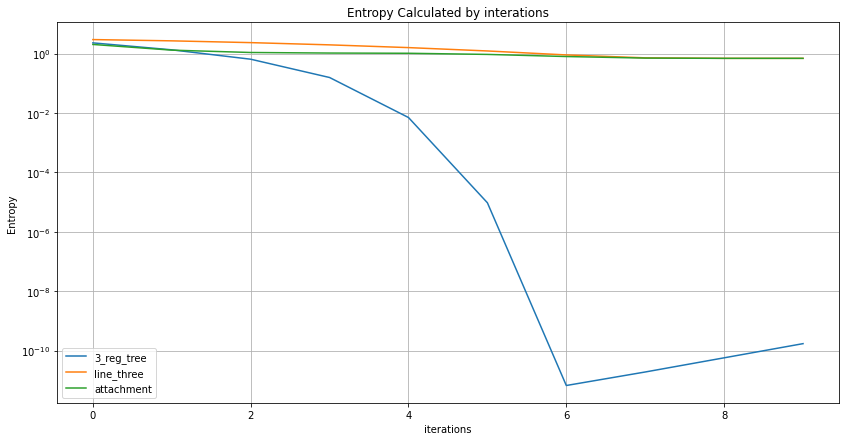

In [219]:
plt.figure(figsize=(14, 7))
plt.semilogy(final_df_1['interation'],final_df_1['entropy'], label = '3_reg_tree')
plt.semilogy(final_df_2['interation'],final_df_2['entropy'], label = 'line_three')
plt.semilogy(final_df_3['interation'],final_df_3['entropy'], label = 'attachment')
plt.title("Entropy Calculated by interations")
plt.xlabel("iterations")
plt.ylabel("Entropy")
plt.grid()
plt.legend()
plt.show()

In [220]:
final_df_2

,interation,entropy,u_calculated
0,0,2.969450,"[0.006010518407212619, 0.017280240420736333, 0..."
1,1,2.690532,"[0.0001079447186091113, 0.0014941650374380587,..."
2,2,2.344657,"[3.4953671269633134e-08, 7.657088891392898e-06..."
3,3,1.971742,"[3.665277320266672e-15, 1.77497980841964e-10, ..."
4,4,1.593772,"[4.030277350337954e-29, 9.452050307366953e-20,..."
5,5,1.228163,"[4.8729406561926547e-57, 2.680237652674719e-38..."
6,6,0.903387,"[7.123665191626087e-113, 2.1551021624426192e-7..."
7,7,0.720560,"[1.522398172867385e-224, 1.3933395991656405e-1..."
8,8,0.693458,"[0.0, 5.824185715761354e-298, 1.33702047030512..."
9,9,0.693147,"[0.0, 0.0, 0.0, 5.634600524292219e-307, 3.6517..."
